In [1]:
%load_ext pyinstrument
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm
import copy

local


In [2]:
#%%pyinstrument
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

(1099, 1)

In [3]:
def get_drift(model, data):
    inferred_data = model.infer([data])[0]
    obs = model.results['obs']
    obs_AIRS, obs_FGS = model.results['model_mean'].m['signal'].m['main'].m['drift'].split_obs(obs)
    obs_AIRS.labels = model.results['model_mean'].m['signal'].m['main'].m['drift'].m['AIRS'].get_prediction(obs_AIRS)    
    drift = obs_AIRS.export_matrix(True)
    return drift, model

In [7]:
%%time
import gp
import ariel_gp
import ariel_load_FGS
importlib.reload(ariel_load_FGS)
importlib.reload(ariel_load)
kgs.profiling=False
kgs.debugging_mode=1
kgs.sanity_checks_active=False
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.use_training_labels = True
model.starter_model.do_plots = False
model.plot_final = False
model.plot_simple = False
model.model_options.include_background = False
model.model_options.n_iter = 4
#print('!!!')
model.train(train_data)
#model.starter_model.loaders[0].cache_steps = [5]

for ii in range(2):                
    pass
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
#model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
#model.loaders[0].cache_steps = []
model.starter_model.loaders = model.loaders


loaders = model.starter_model.loaders
#loaders[0].cache_steps= []
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = True
loaders[0].apply_full_sensor_corrections.restore_invalids = True
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
# old_weights = copy.deepcopy(ariel_load_FGS.FGS_weights)
# ariel_load_FGS.FGS_weights *= 0
# ariel_load_FGS.FGS_weights[0,0] = old_weights[0,0]
#print(ariel_load_FGS.FGS_weights)
#ariel_load_FGS.FGS_weights[3] = 1
model.model_options.FGS_order = 3
#model.model_options.AIRS_order = 3
#loaders[0].apply_wavelength_binning.options.use_sum = True
# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = np.inf
# loaders[1].apply_wavelength_binning.sequential_fit = True


            
#model.loaders[0].cache_steps = [5]
#data = [train_data[[d.planet_id for d in train_data].index(1843015807)]] # ingress and egress obscured
#1349926825
#data = train_data[1:2]
#data = [train_data[[d.planet_id for d in train_data].index(1843015807)]]
#data = train_data[2:3]
#data = [train_data[[d.planet_id for d in train_data].index(2270815333)]] # ingress and egress obscured
#data= copy.deepcopy(data)
#for d in data:
#    d.load_to_step(5,model.loaders)
    #d.transits[0].data[1].noise_est*=1000
#print('!!!')
#d.transits = d.transits[1:]
#inferred_data = model.infer(data)


CPU times: user 482 ms, sys: 199 ms, total: 681 ms
Wall time: 1.74 s


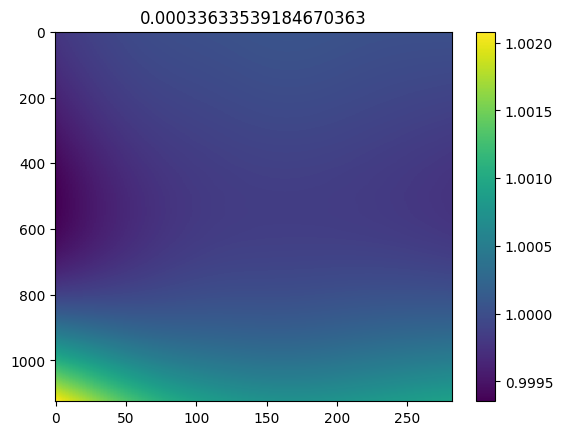

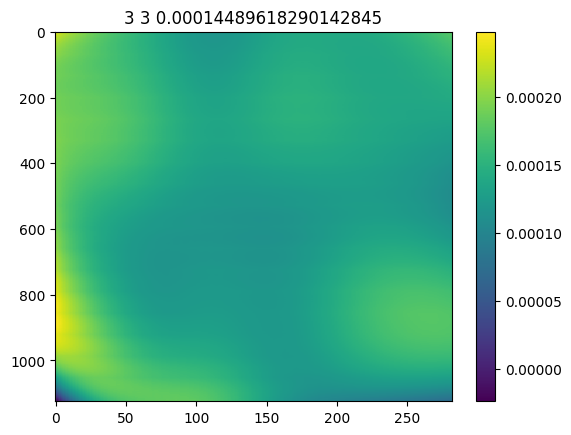

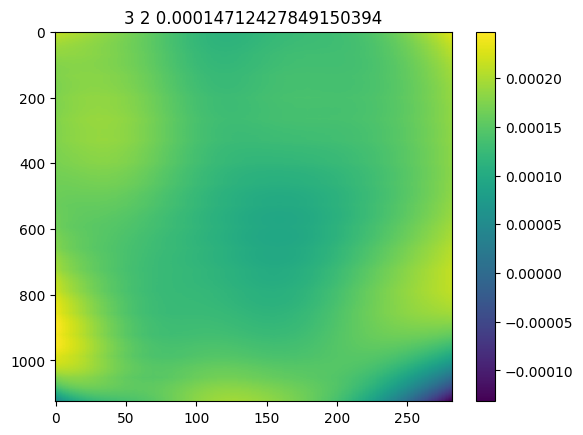

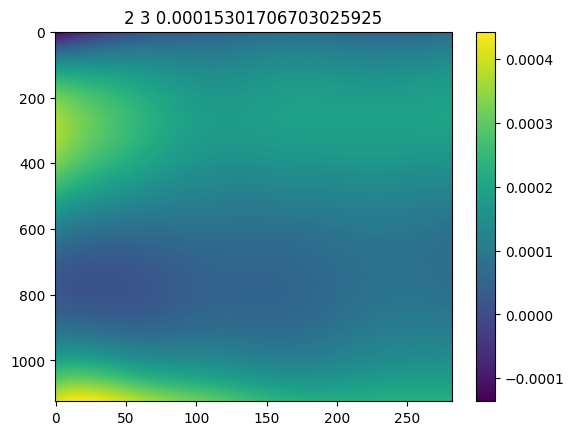

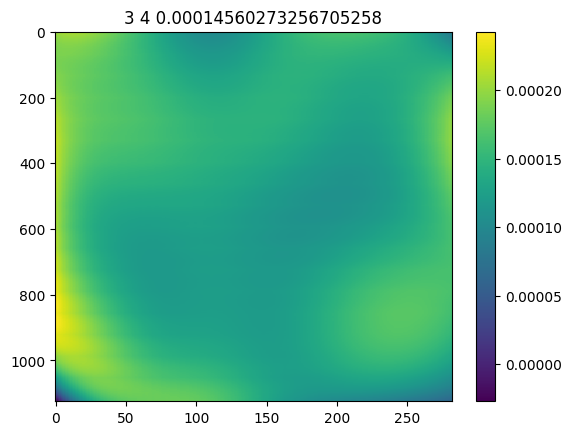

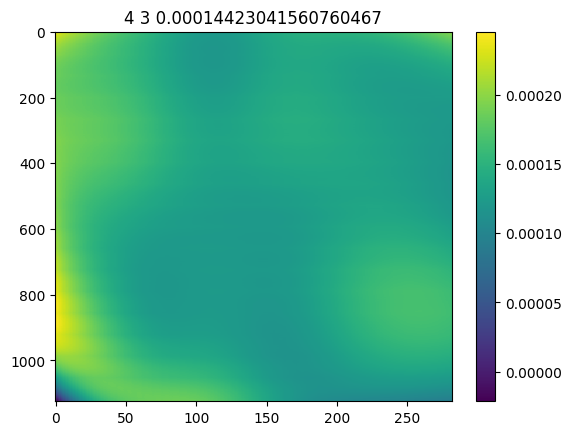

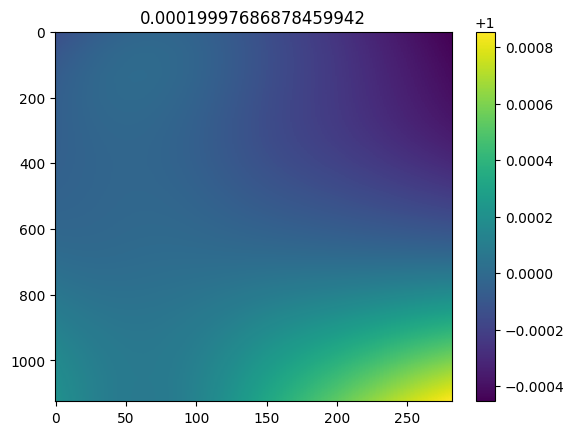

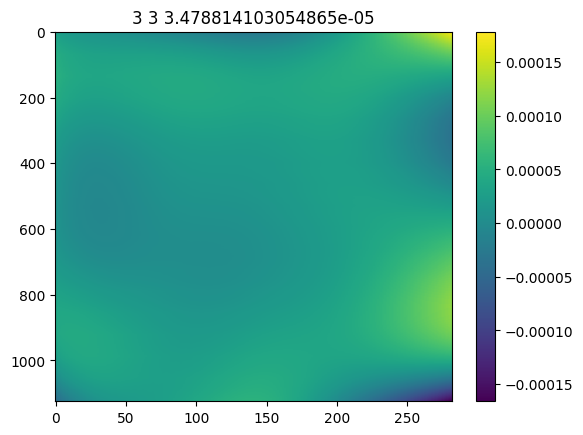

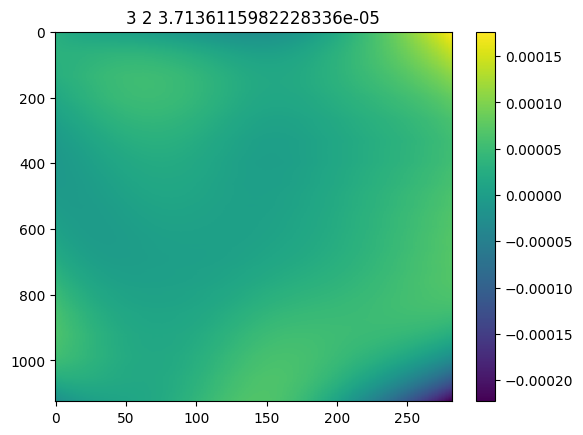

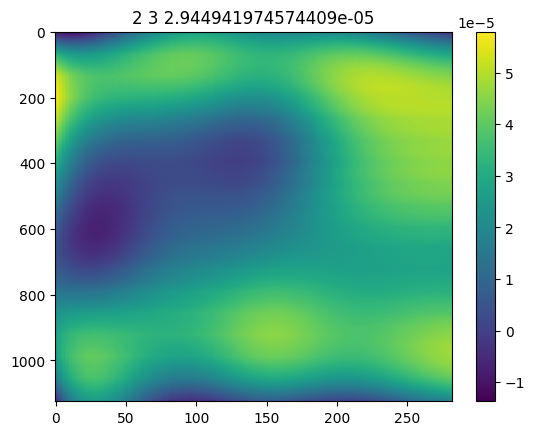

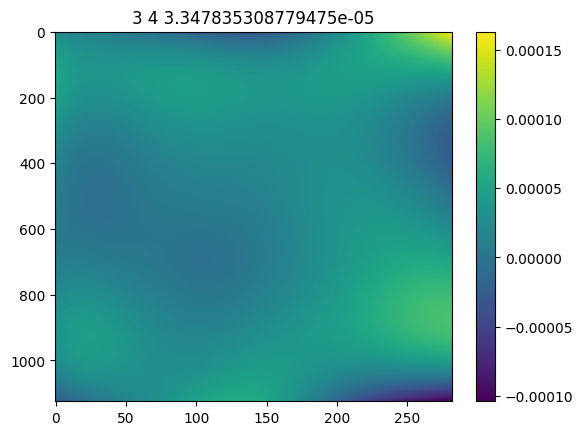

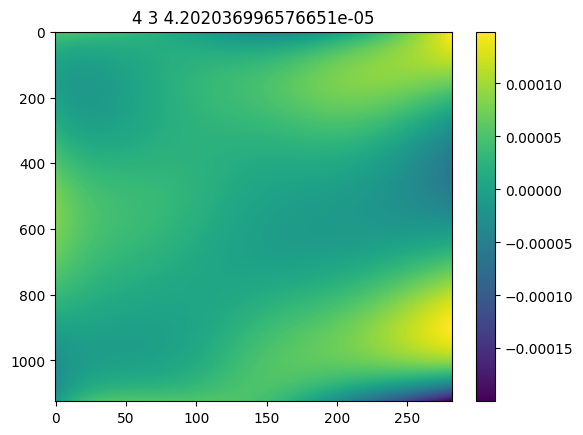

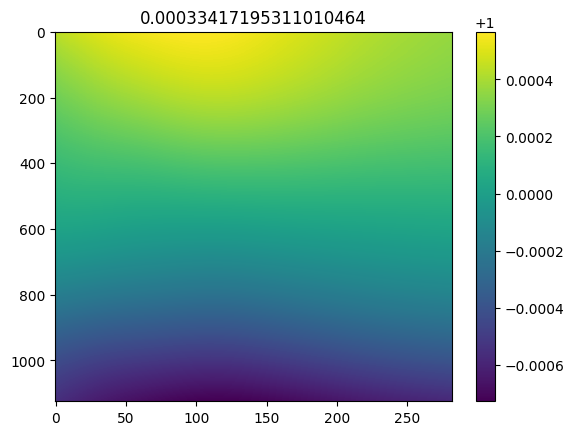

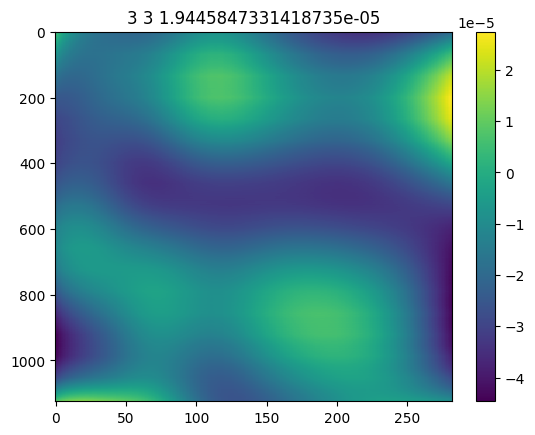

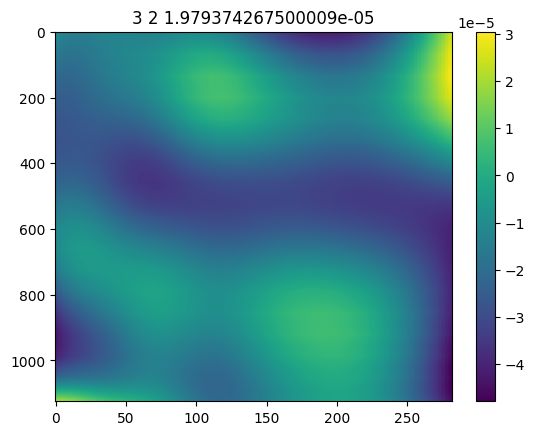

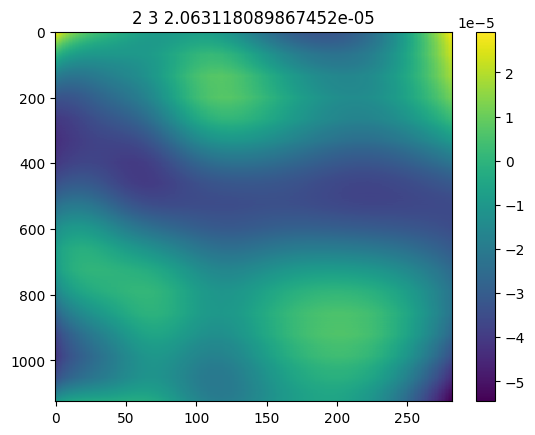

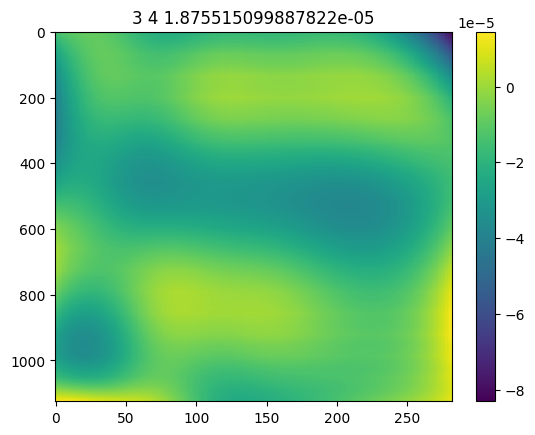

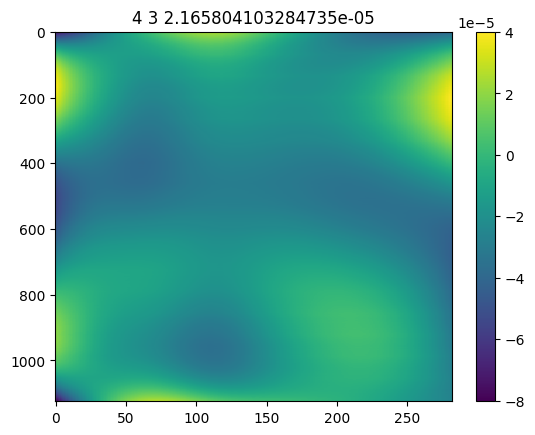

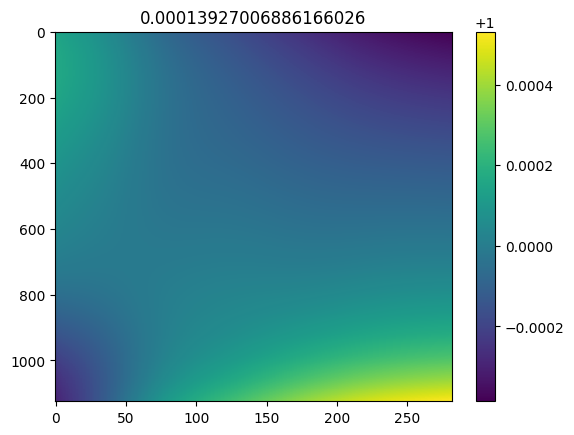

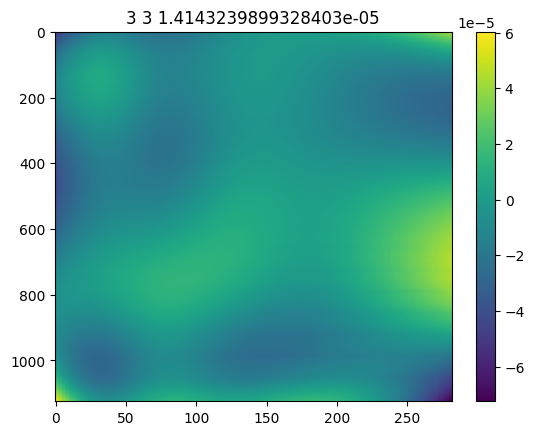

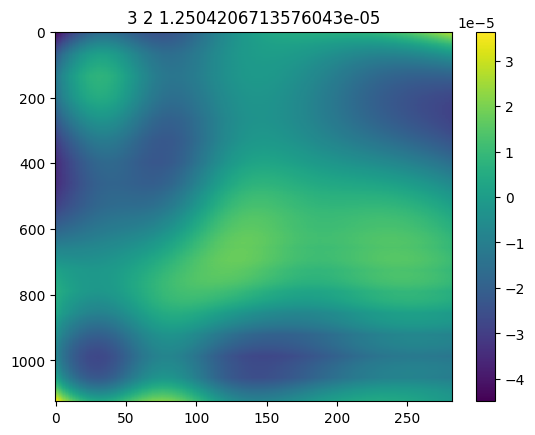

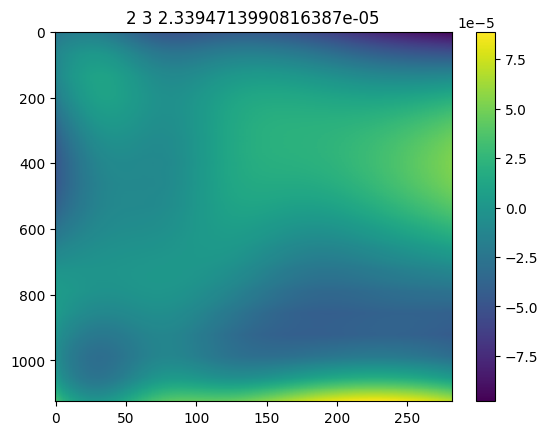

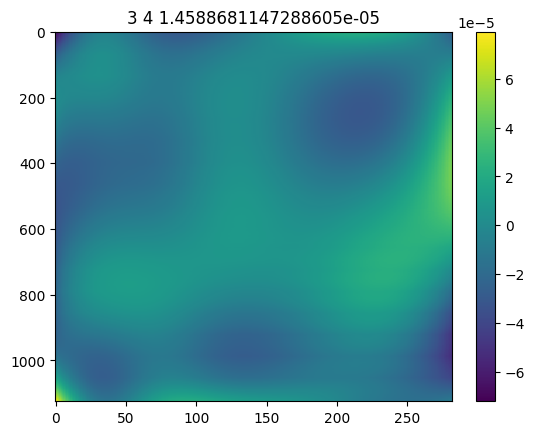

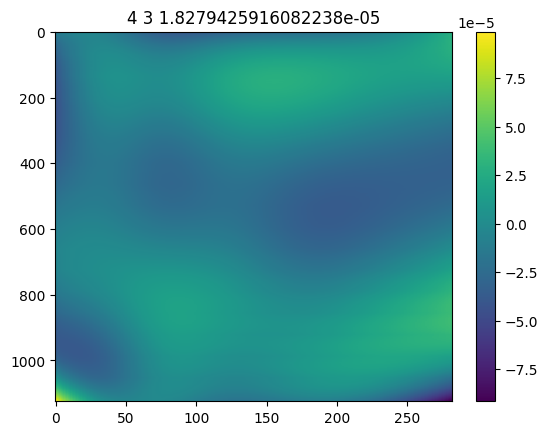

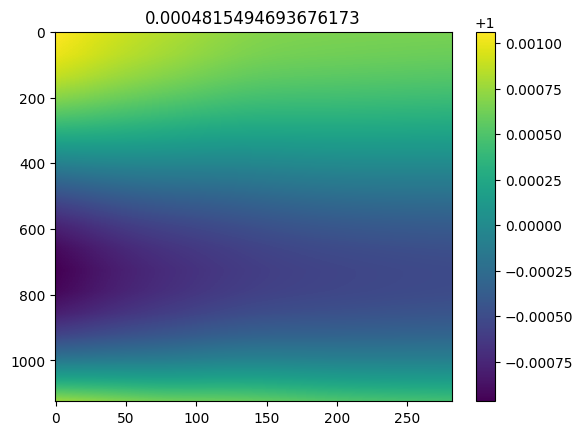

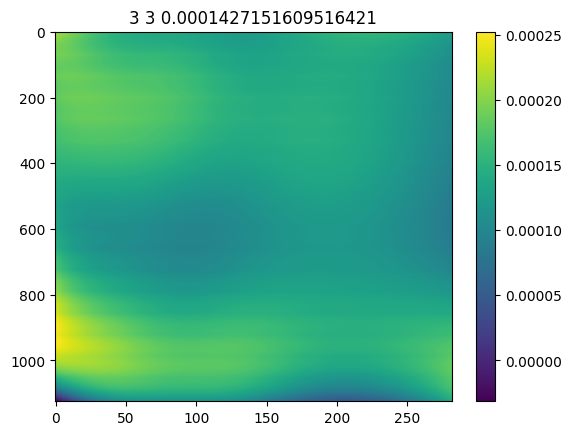

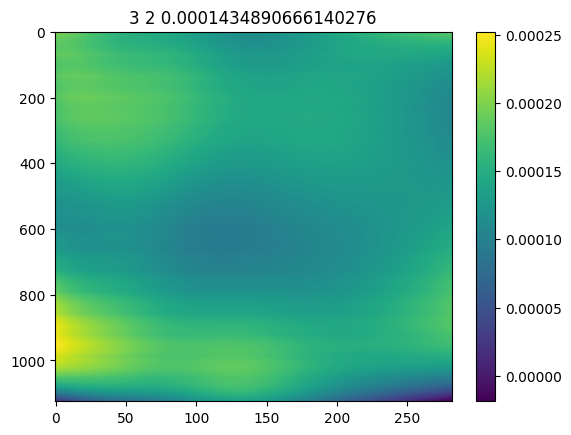

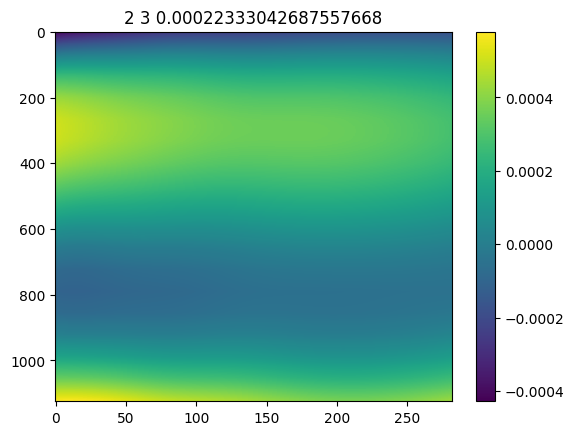

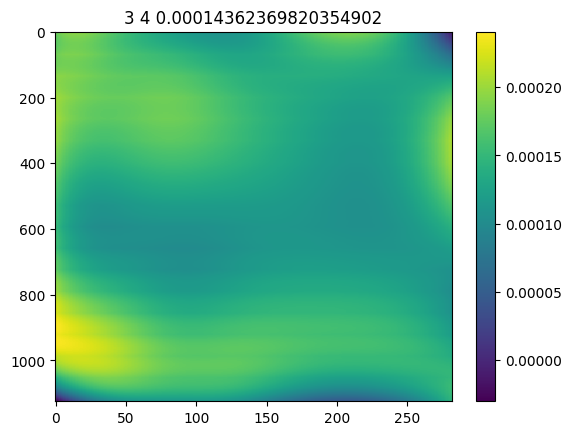

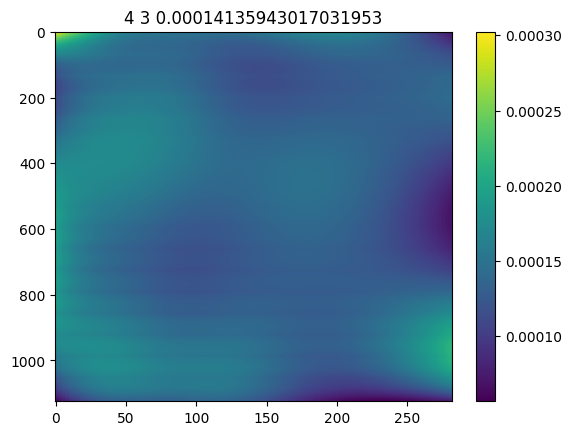

In [11]:
def dooo(order_time, order_wavelength):
    model2 = copy.deepcopy(model)
    model2.model_options.AIRS_order_time = order_time
    model2.model_options.AIRS_order_wavelength = order_wavelength
    dr2,mod = get_drift(model2, data)    
    # plt.figure()
    # plt.imshow(dr2, aspect='auto', interpolation='none')
    # plt.colorbar()
    plt.figure()
    plt.imshow(dr-dr2, aspect='auto', interpolation='none')
    plt.colorbar()
    plt.title(f'{order_time} {order_wavelength} {kgs.rms(dr-dr2)}')
    plt.pause(0.001)
    
for data in train_data[:5]:
    dr,_ = get_drift(copy.deepcopy(model), data)
    plt.figure()
    plt.imshow(dr, aspect='auto', interpolation='none')
    plt.colorbar()
    plt.title(kgs.rms(dr-1))
    plt.pause(0.001)    
    dooo(3,3)
    dooo(3,2)
    dooo(2,3)
    dooo(3,4)
    dooo(4,3)
    

In [ ]:
params = mod.results['model_mean'].m['signal'].m['main'].m['drift'].m['AIRS'].get_parameters()

In [ ]:
def doo(vals):
    #plt.figure()
    #plt.imshow(vals)
    #plt.colorbar()
    plt.figure()
    plt.imshow(vals/vals[:,0][:,None])
    plt.colorbar()
doo(params.reshape(3,4))
doo(params.reshape(4,3))
doo(params.reshape(3,4).T)
doo(params.reshape(4,3).T)